# Fase 2: MLOps - Refactored Modeling Pipeline

This notebook implements the second phase of the MLOps project for the "Insurance Company Benchmark" (COIL 2000) dataset. 

**Objective:** Predict whether a client will purchase a caravan insurance policy.

This version refactors the original notebook by moving all reusable logic (data cleaning, feature engineering, and model training) into Python modules within the `src/` directory, following MLOps best practices.

## 1. Setup and Imports

First, we add the project's root directory to the system path to allow imports from `src/`. We then import our custom modules and necessary libraries.

In [1]:
import sys
import os
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Add the project root (assuming this notebook is in 'notebooks/') to the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules from src/
from src import config
from src import dataset
from src import features
from src.modeling import train
from src import plots 
import matplotlib.pyplot as plt
import seaborn as sns 

## 2. Data Cleaning

We execute the complete data cleaning pipeline defined in `src/dataset.py`. This script loads the raw data, repairs out-of-range values, imputes missing data, and saves the cleaned result to `data/processed/`.

In [2]:
dataset.clean_raw_data(
    in_path=config.RAW_DATA_PATH,
    out_path=config.PROCESSED_DATA_PATH,
    columns=config.COLS,
    expected_ranges=config.EXPECTED_RANGES,
    rare_threshold=config.RARE_THRESHOLD
)

2025-10-28 20:44:39,280 - INFO - --- Data Cleaning Pipeline Started ---
2025-10-28 20:44:39,459 - INFO - Loaded raw data: (5938, 86)
2025-10-28 20:44:39,459 - INFO - MOSTYPE: 75 (1.26%) values out of range [1,41]
2025-10-28 20:44:39,459 - INFO -   -> Widespread: Clipped to range
2025-10-28 20:44:39,459 - INFO - MAANTHUI: 69 (1.16%) values out of range [1,10]
2025-10-28 20:44:39,459 - INFO -   -> Widespread: Clipped to range
2025-10-28 20:44:39,459 - INFO - MGEMOMV: 64 (1.08%) values out of range [1,6]
2025-10-28 20:44:39,475 - INFO -   -> Widespread: Clipped to range
2025-10-28 20:44:39,475 - INFO - MGEMLEEF: 73 (1.23%) values out of range [1,6]
2025-10-28 20:44:39,475 - INFO -   -> Widespread: Clipped to range
2025-10-28 20:44:39,475 - INFO - MOSHOOFD: 58 (0.98%) values out of range [1,10]
2025-10-28 20:44:39,475 - INFO -   -> Rare: Set to NaN (will be imputed)
2025-10-28 20:44:39,482 - INFO - CARAVAN: 22 (0.37%) values out of range [0,1]
2025-10-28 20:44:39,482 - INFO -   -> Rare: Se

## 3. Load Processed Data

Now we load the clean, processed data. We also assign the descriptive column names from `src/config.py` for better readability.

In [3]:
df_cleaned = dataset.load_processed_data(config.PROCESSED_DATA_PATH)

# Assign descriptive names
df_cleaned.columns = config.LONG_NAMES

df_cleaned.head()

2025-10-28 20:44:39,936 - INFO - Loaded processed data from: C:\Users\jorge\OneDrive\Documents\GIT\insurance_company_project\data\processed\insurance_company_cleaned_modified.csv


,customer_subtype,num_houses,avg_household_size,avg_age_band,customer_main_type,pct_roman_catholic,pct_protestant,pct_other_religion,pct_no_religion,pct_married,...,num_private_accident,num_family_accident,num_disability_ins,num_fire_policies,num_surfboard_policies,num_boat_policies,num_bicycle_policies,num_property_ins,num_social_security,target_caravan
0,33,1,3,2,8,0,5,1,3,7,...,1,1,1,1,1,1,1,1,1,0
1,37,1,2,2,8,1,4,0,4,6,...,1,1,1,1,1,1,1,1,1,0
2,37,1,2,2,8,0,4,2,4,3,...,1,1,1,1,1,1,1,1,1,0
3,9,1,3,3,3,2,3,2,4,5,...,1,1,1,1,1,1,1,1,1,0
4,40,1,4,2,10,1,4,1,4,7,...,1,1,1,1,1,1,1,1,1,0


## 4 Exploratory Data Analysis (EDA)

With the clean data loaded, we can run the exploratory analysis. Instead of writing the visualization code here, we call the reusable functions from `src/plots.py`.

2025-10-28 20:44:39,979 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-28 20:44:39,987 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


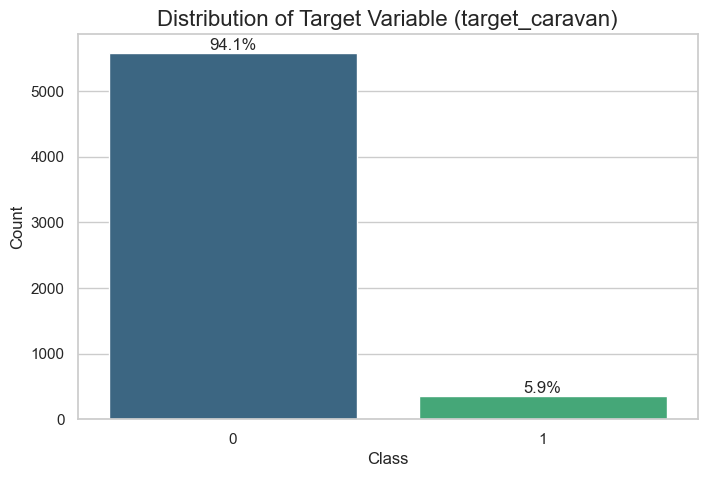

In [4]:
# 1. Target Variable Distribution
plots.plot_target_distribution(df_cleaned, config.TARGET_COL)

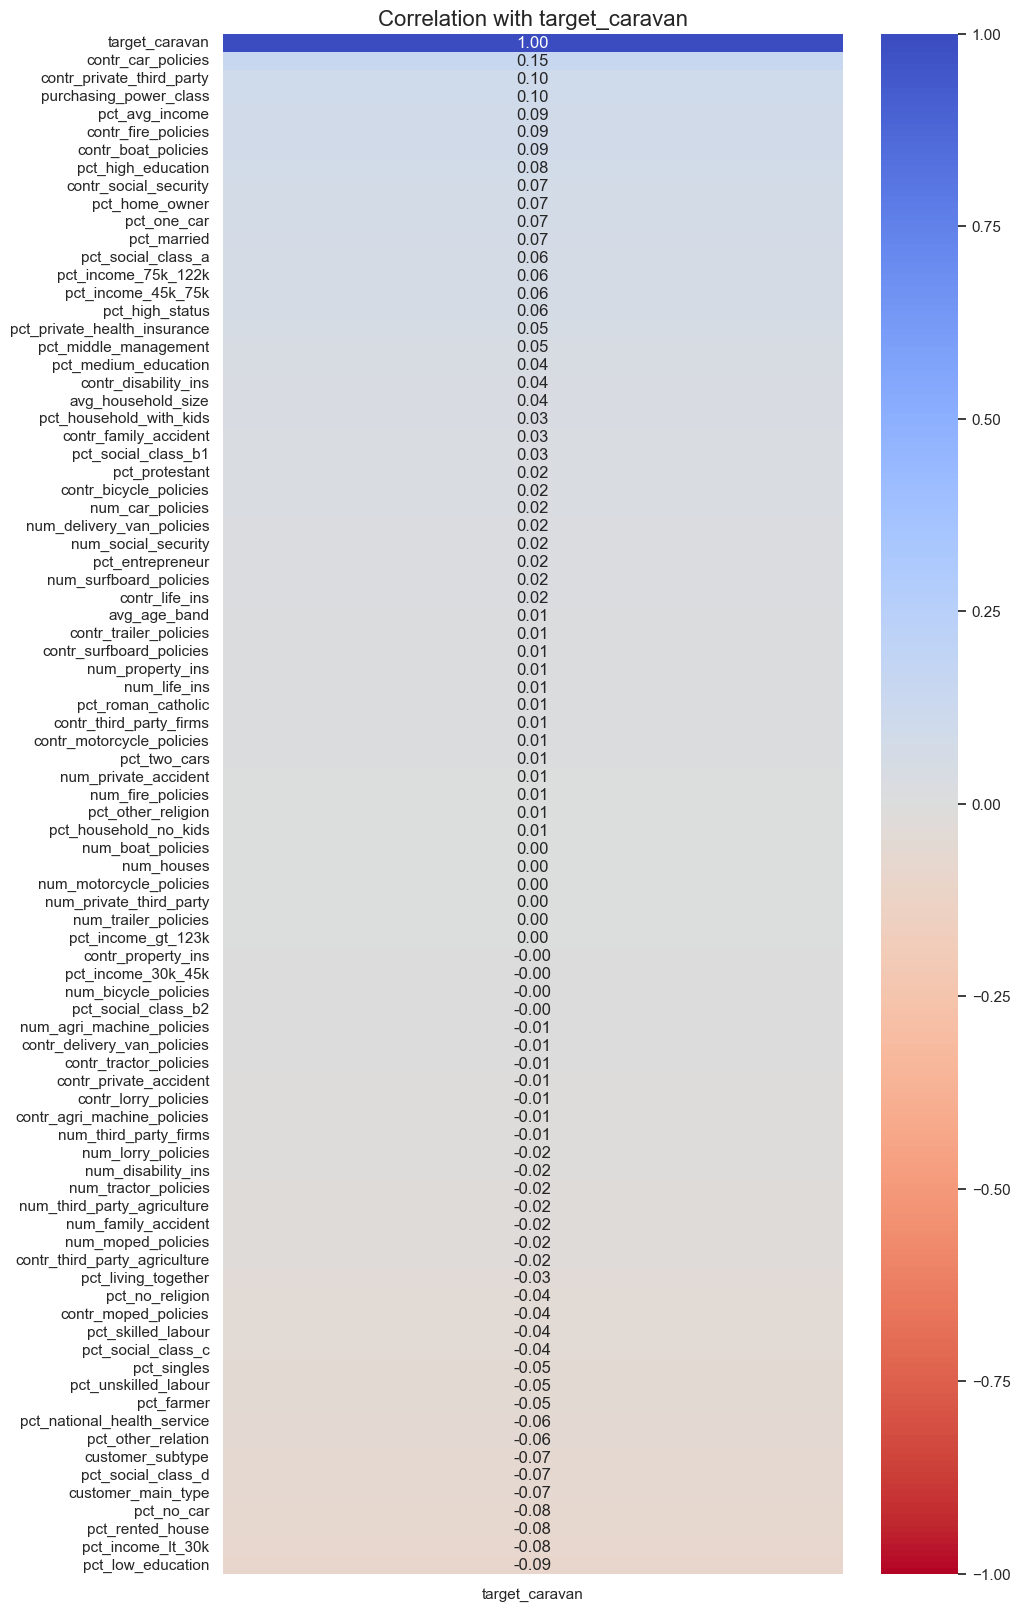

In [5]:
# 2. Feature Correlation with Target
plots.plot_correlation_heatmap(df_cleaned, target_col=config.TARGET_COL)

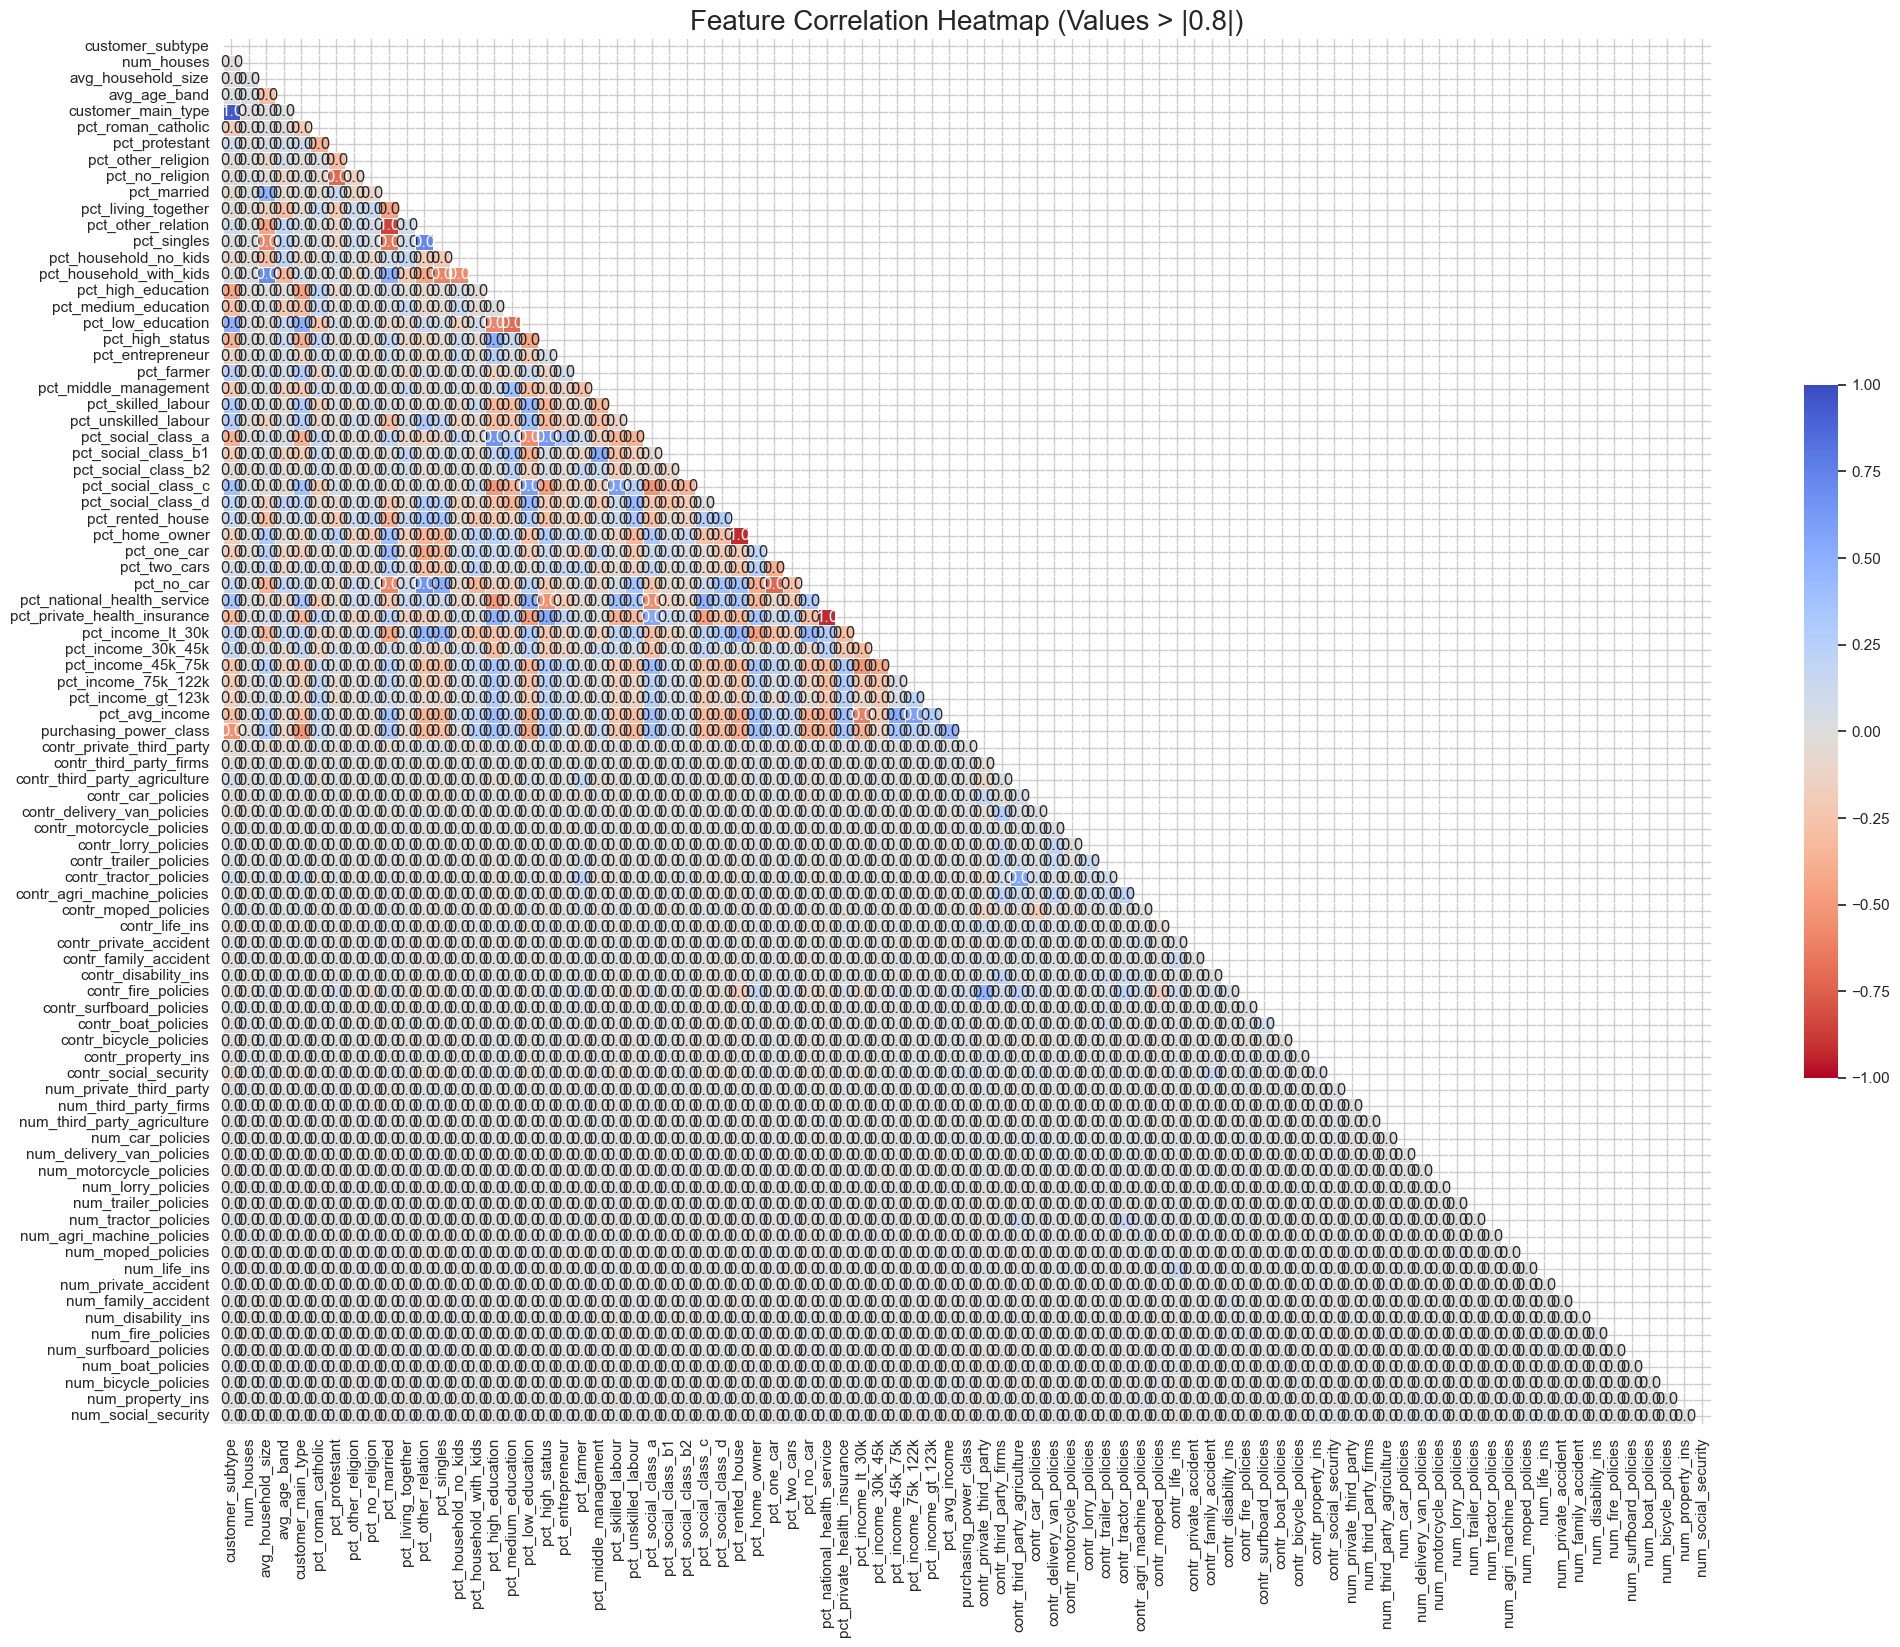

In [6]:
# View the full heatmap
plots.plot_correlation_heatmap(df_cleaned.drop(columns=config.TARGET_COL), corr_threshold=0.8)

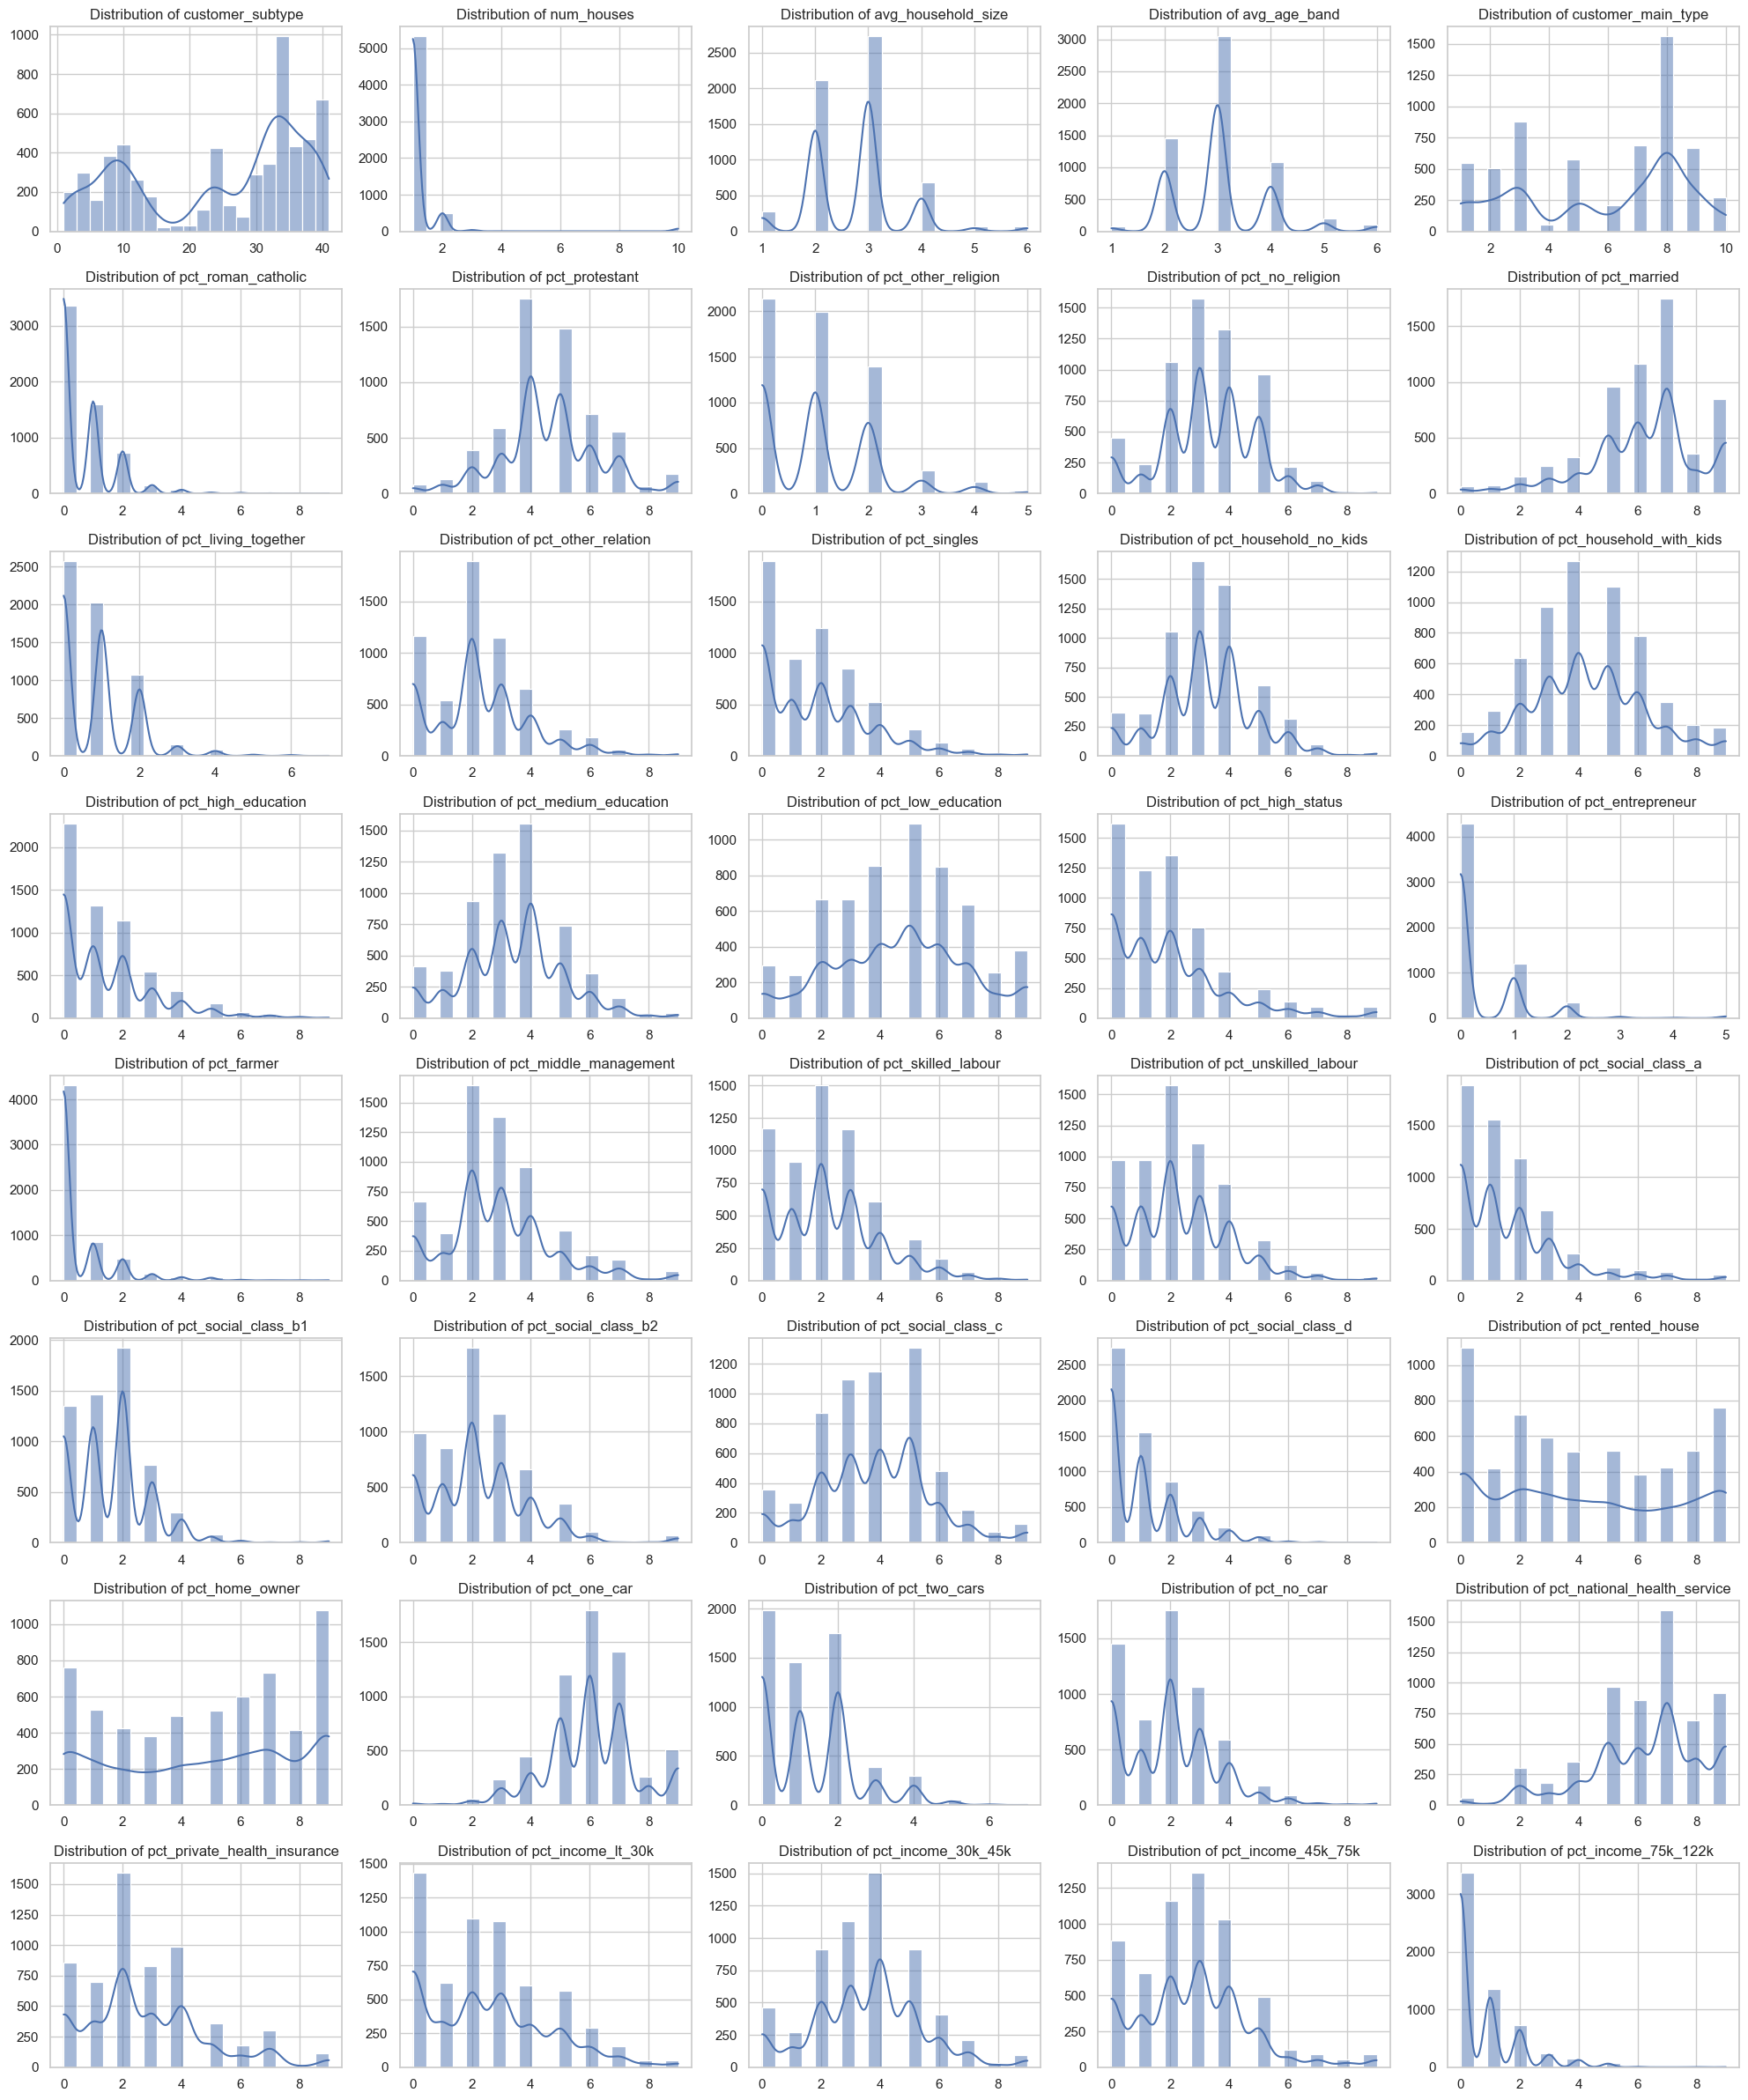

In [7]:
# 3. Distribution of the first 40 features
first_40_features = config.LONG_NAMES[:40]
plots.plot_feature_histograms(df_cleaned, first_40_features, n_cols=5)

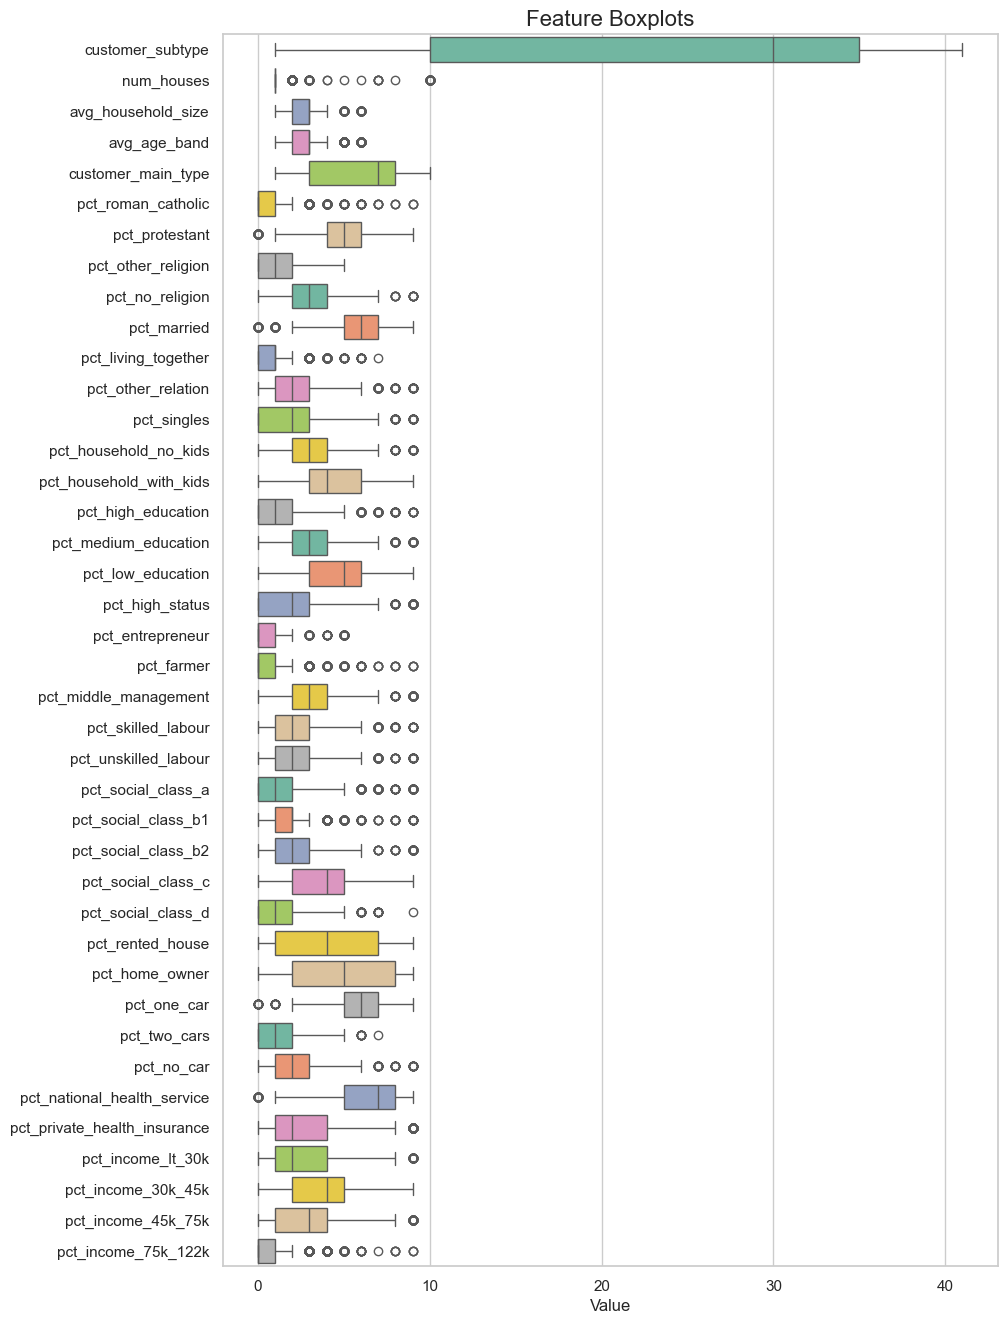

In [8]:
# 4. Boxplots of the first 40 features
plots.plot_feature_boxplots(df_cleaned, first_40_features)

## 5. Feature Engineering & Selection

We apply the `prune_by_correlation` function from `src/features.py` to remove highly collinear variables, reducing redundancy.

In [9]:
df_pruned, dropped_cols = features.prune_by_correlation(
    df_cleaned,
    target_col=config.TARGET_COL,
    thr=config.PRUNING_THRESHOLD,
    random_state=config.RANDOM_STATE
)

print(f"Original shape: {df_cleaned.shape} -> Pruned shape: {df_pruned.shape}")

Correlation Pruning: Dropped 4 columns with threshold > 0.85
Original shape: (5938, 86) -> Pruned shape: (5938, 82)


## 6. Define Features (X) and Target (y)

We separate our dataset into the feature matrix `X` and the target vector `y`.

In [10]:
y = df_pruned[config.TARGET_COL].astype(int)
X = df_pruned.drop(columns=[config.TARGET_COL])

## 7. Data Splitting

We use the `split_data` function from `src/modeling/train.py` to create stratified training (60%), validation (20%), and test (20%) sets.

In [11]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train.split_data(
    X,
    y,
    random_state=config.RANDOM_STATE
)

Data split complete:
  Train: 3562 samples
  Valid: 1188 samples
  Test:  1188 samples


## 8. Create Preprocessing Pipeline

We instantiate our `ColumnTransformer` using the `create_preprocessor` factory function from `src/features.py`. This object will be the first step in our `scikit-learn` modeling pipelines.

In [12]:
# Cell for Step 7
preprocessor = features.create_preprocessor(
    available_cols=X.columns,
    static_nominal_cols=config.NOMINAL_COLS,
    static_ordinal_cols=config.ORDINAL_COLS,
    static_numeric_cols=config.NUMERIC_DISCRETE_COLS
)

preprocessor

Preprocessor created. Columns to be processed:
  Nominal: 1 (out of 2 defined)
  Ordinal: 57 (out of 60 defined)
  Numeric: 23 (out of 23 defined)


,transformers,"[('nom', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


## 9. Model 1: Logistic Regression (Baseline)

We run our baseline model. The `train_logistic_regression` function encapsulates all steps:

1.  Building the `Pipeline` (preprocessor + model).
2.  Fitting the model on `(X_train, y_train)`.
3.  Finding the optimal G-Mean threshold on `(X_valid, y_valid)`.
4.  Evaluating the final model on `(X_test, y_test)` using the chosen threshold."

In [13]:
lr_results = train.train_logistic_regression(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    preprocessor,
    random_state=config.RANDOM_STATE
)


--- Training Model 1: Logistic Regression ---
Training complete in 2.68s
--- Logistic Regression Evaluation (on Test Set) ---
  model: Logistic Regression
  best_threshold_gmean: 0.4200
  valid_gmean: 0.6655
  test_pr_auc: 0.1576
  test_roc_auc: 0.6755
  test_gmean: 0.6142
  test_recall (TPR): 0.6000
  test_specificity (TNR): 0.6288
  test_f1_score: 0.1594
  test_confusion_matrix: 
[[703 415]
 [ 28  42]]


## 10. Model 2: XGBoost (Optimized)

We run our advanced model. The `train_xgboost` function encapsulates all steps:
1.  Building the `Pipeline` (preprocessor + model).
2.  Setting up `RandomizedSearchCV`.
3.  Fitting the search on `(X_train, y_train)`.
4.  Finding the optimal G-Mean threshold on `(X_valid, y_valid)` using the best model.
5.  Evaluating the final model on `(X_test, y_test)` using the chosen threshold.

In [14]:
xgb_results = train.train_xgboost(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    preprocessor, 
    random_state=config.RANDOM_STATE
)


--- Training Model 2: XGBoost w/ Hyperparameter Search ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

RandomizedSearchCV complete in 8.01s
Best AP (cv): 0.1284
Best Params:
  subsample: 1.0
  scale_pos_weight: 15
  reg_lambda: 5.0
  reg_alpha: 0.1
  n_estimators: 800
  min_child_weight: 1
  max_depth: 6
  learning_rate: 0.1
  gamma: 0.5
  colsample_bytree: 0.7

--- XGBoost Evaluation (on Test Set) ---
  model: XGBoost
  best_threshold_gmean: 0.0900
  valid_gmean: 0.6853
  test_pr_auc: 0.1152
  test_roc_auc: 0.6916
  test_gmean: 0.6481
  test_recall (TPR): 0.6286
  test_specificity (TNR): 0.6682
  test_f1_score: 0.1814
  test_confusion_matrix: 
[[747 371]
 [ 26  44]]


## 11. Conclusion

The pipeline has been successfully refactored. Both the baseline and optimized models were trained and evaluated using a modular, reproducible, and maintainable codebase. The results dictionaries (`lr_results` and `xgb_results`) contain all metrics for comparison and reporting.